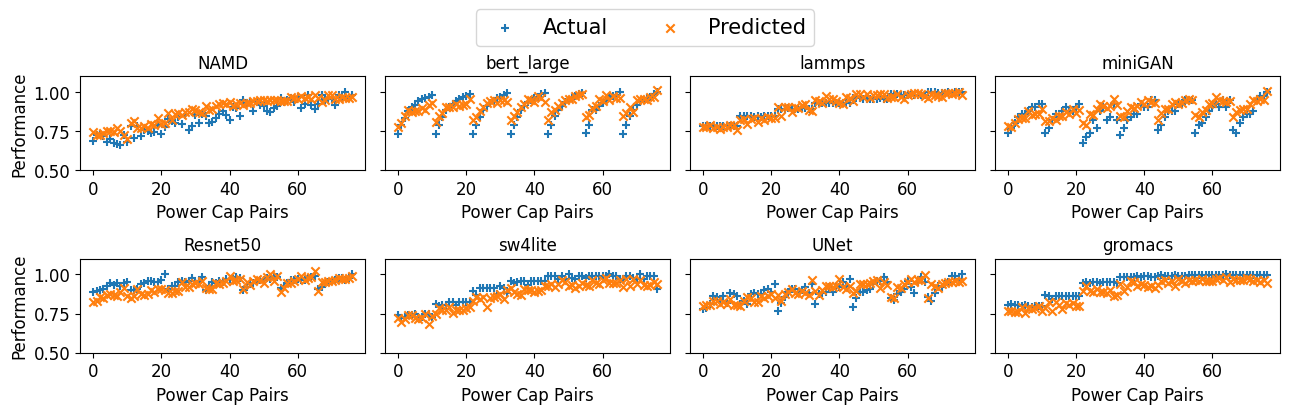

In [45]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Reload performance matrix
performance_matrix_path = "./prediction_res/performance_matrix.csv"
if os.path.exists(performance_matrix_path):
    performance_matrix = pd.read_csv(performance_matrix_path, index_col=0)

    # Convert index to tuple (if stored as a string)
    performance_matrix.index = performance_matrix.index.map(ast.literal_eval)

    # Ensure index is a MultiIndex
    performance_matrix.index = pd.MultiIndex.from_tuples(performance_matrix.index, names=["CPU Power Cap", "GPU Power Cap"])

    # Filter indices to include only those (140, 150) and onwards
    filtered_indices = performance_matrix.index[performance_matrix.index >= (140, 150)]
    performance_matrix = performance_matrix.loc[filtered_indices]
else:
    raise FileNotFoundError("Performance matrix file not found.")

# List of applications
apps = ["NAMD", "bert_large", "lammps", "miniGAN", "Resnet50", 
        "sw4lite", "UNet", "gromacs"]

# Path to validation files
validation_path = "./ecp_power_cap_res/2_dual_cap/validation/"

# Define figure size and layout (2 rows, 5 columns)
fig, axes = plt.subplots(2, 4, figsize=(13, 4), sharey=True)

# Iterate over applications and plot in respective subplots
for idx, app in enumerate(apps):
    file_path = os.path.join(validation_path, f"{app}_performance.csv")
    
    if not os.path.exists(file_path):
        print(f"Skipping {app}: File not found")
        continue

    # Load application performance data
    app_data = pd.read_csv(file_path)

    # Ensure required columns exist
    if "CPU Power Cap" not in app_data.columns or "GPU Power Cap" not in app_data.columns or "Performance" not in app_data.columns:
        print(f"Skipping {app}: Missing necessary columns")
        continue

    # Create index column as tuples
    app_data["index"] = list(zip(app_data["CPU Power Cap"], app_data["GPU Power Cap"]))
    
    # Set the index to match performance_matrix
    app_data.set_index("index", inplace=True)

    # Convert app_data index to MultiIndex
    app_data.index = pd.MultiIndex.from_tuples(app_data.index, names=["CPU Power Cap", "GPU Power Cap"])

    # Filter matched indices starting from (140, 150)
    common_indices = app_data.index.intersection(filtered_indices)
    
    if len(common_indices) == 0:
        print(f"Skipping {app}: No matching power cap pairs after (140, 150)")
        continue

    # Extract actual and predicted performance
    actual_performance = app_data.loc[common_indices, "Performance"]
    predicted_performance = performance_matrix.loc[common_indices, app]

    # Determine subplot position
    ax = axes[idx // 4, idx % 4]

    # Plot actual and predicted performance
    ax.scatter(range(len(common_indices)), actual_performance, label="Actual", marker="+")
    ax.scatter(range(len(common_indices)), predicted_performance, label="Predicted", marker="x")

    # Set labels and title
    if idx % 4 == 0:  # Only set y-axis label for first column
        ax.set_ylabel("Performance", fontsize=12)

    ax.set_xlabel("Power Cap Pairs",fontsize=12)
    ax.set_title(app, fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # ax.grid()
    ax.set_ylim(0.5, 1.1)  # Set y-axis scale from 0 to 1.1
    ax.set_yticks([ 0.5, 0.75, 1])

# Adjust layout and add legend
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for legend
fig.legend(["Actual", "Predicted"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.05),fontsize=15)
fig.savefig("./fig/actual_predict.png", dpi=300, bbox_inches="tight")

plt.show()

